# A Post Office – A Real Life Story

*Paul Bayer, 2017-07-27*

Let us begin with an everyday story: there is a small post office with one clerk serving the arriving customers. Customers have differing wishes leading to different serving times, from `1 - 5 minutes`. We have to add a little variation to serving times counting for variation in customer habits and clerk performance. The arrival rate of customers is about 18 per hour, every `3.33 minutes` or `3 minutes, 20 seconds` on average. Our post office is small and customer patience is limited, so queue length is limited to 5 customers. 

We have provided 10% extra capacity, so our expectation is that there should not be too many customers discouraged for long waiting times or for full queues.

![](pictures/PostOffice.png)

Let's do a simulation in [```Julia```](https://julialang.org) using [```SimJulia```](https://github.com/BenLauwens/SimJulia.jl). We need 

1. a source: all the **people**, providing an unlimited supply for customers,
2. **customers** with their demands and their limited patience,
3. a **queue** and
4. our good old **clerk**.

In [1]:
using SimJulia, Distributions
include("src/simlog.jl")

function people(sim::Simulation, β::Float64, queue::Array{Int64,1}, clerk::Resource)
    i = 1
    while true
        Δt = rand(Exponential(β))
        yield(Timeout(sim, Δt))
        @process customer(sim, i, queue, clerk)
        i += 1
    end
end

function customer(sim::Simulation, n::Int64, queue::Array{Int64,1}, clerk::Resource)
    wt = 0
    if length(queue) ≥ 5
        wt = -1
        logevent(sim, n, queue, "leaves - queue is full!", wt)
        return
    else
        arrivaltime = now(sim)
        logevent(sim, n, queue, "enqueues", wt)
        push!(queue, n)
        yield(Request(clerk))
        shift!(queue)
        logevent(sim, n, queue, "now being served", wt)
        Δt = rand(DiscreteUniform(1, 5)) + randn()*0.2
        yield(Timeout(sim, Δt))
        yield(Release(clerk))
        wt = now(sim)-arrivaltime
        logevent(sim, n, queue, "leaves", wt)
    end
end

simlog = newlog()                                                # provide some data logging
ev = Dict("customer"=>0, "queue_len"=>0, "status"=>"", "wait_time"=>0)
dict2log(simlog, ev)

function logevent(sim::Simulation, customer, queue, status, wt)
    ev["customer"] = customer
    ev["queue_len"] = length(queue)
    ev["status"] = status
    if wt != 0
        ev["wait_time"] = wt
    end
    lognow(sim, simlog)
end

srand(1234)  # seed random number generator for reproducibility
queue = Int64[]

sim = Simulation()
clerk = Resource(sim, 1)
@process people(sim, 3.333, queue, clerk)
run(sim, 600)
d = log2df(simlog)                   # logged data to dataframe
println(queue, " yet in queue")

Int64[] yet in queue


In [2]:
d

,time,customer,queue_len,status,wait_time
1,8.277523406177503,1,0,enqueues,0.0
2,8.277523406177503,1,0,now being served,0.0
3,13.096940547404454,1,0,leaves,4.8194171412269515
4,13.332696522897287,2,0,enqueues,4.8194171412269515
5,13.332696522897287,2,0,now being served,4.8194171412269515
6,17.439259179331195,2,0,leaves,4.106562656433908
7,17.68732645485233,3,0,enqueues,4.106562656433908
8,17.68732645485233,3,0,now being served,4.106562656433908
9,18.835329261870097,4,0,enqueues,4.106562656433908
10,19.583929730713674,3,1,leaves,1.8966032758613451


In [3]:
tail(d)

,time,customer,queue_len,status,wait_time
1,590.790577593688,186,1,leaves,4.673814478395798
2,590.790577593688,187,0,now being served,4.673814478395798
3,591.8675254257583,187,0,leaves,2.1805566906148215
4,596.8808579075101,188,0,enqueues,2.1805566906148215
5,596.8808579075101,188,0,now being served,2.1805566906148215
6,597.993226414482,188,0,leaves,1.1123685069719613


In [4]:
nrow(d) # number of rows / registered events

522

In [5]:
describe(d[d[:wait_time] .> 0, :wait_time])

Summary Stats:
Mean:           10.300792
Minimum:        1.112369
1st Quartile:   5.620331
Median:         10.194662
3rd Quartile:   14.332904
Maximum:        21.035988
Length:         499
Type:           Float64
Number Missing: 0
% Missing:      0.000000


In `600` minutes simulation time, we registered `188` customers and `522` events. The mean and median waiting times were slightly above 10 minutes.

In [6]:
by(d, :status, df -> size(df, 1))

,status,x1
1,enqueues,167
2,leaves,167
3,leaves - queue is full!,21
4,now being served,167


Of the `188` customers, `167` participated in the whole process and were served, but `21` left beforehand because the queue was full. 

In [7]:
view(d, d[:wait_time] .< 0)

,time,customer,queue_len,status,wait_time
1,63.10114377128373,24,5,leaves - queue is full!,-1.0
2,66.44284148119657,26,5,leaves - queue is full!,-1.0
3,234.4625822073755,69,5,leaves - queue is full!,-1.0
4,296.4473911757214,87,5,leaves - queue is full!,-1.0
5,297.7386681881535,88,5,leaves - queue is full!,-1.0
6,299.46941323548623,89,5,leaves - queue is full!,-1.0
7,304.09019438966897,91,5,leaves - queue is full!,-1.0
8,304.2694758639154,92,5,leaves - queue is full!,-1.0
9,309.1921637463392,94,5,leaves - queue is full!,-1.0
10,310.80664555034787,96,5,leaves - queue is full!,-1.0


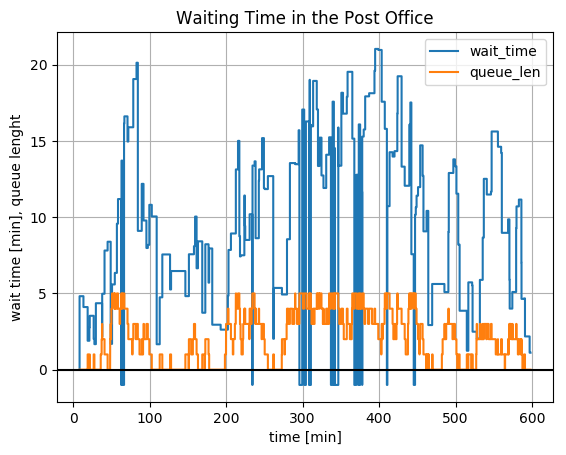

In [8]:
using PyPlot
step(d[:time], d[:wait_time])
step(d[:time], d[:queue_len])
axhline(y=0, color="k")
grid()
xlabel("time [min]")
ylabel("wait time [min], queue lenght")
title("Waiting Time in the Post Office")
legend(["wait_time", "queue_len"]);

Many customers had waiting times of more than 10, 15 up to even 20 minutes. The negative waiting times were the `21` customers, which left because the queue was full.

So many customers will remain angry. If this is the situation all days, our post office will have an evil reputation. What should we do?

## Conclusion

Even if our process runs within predetermined bounds (queue length, customer wishes …), it seems to fluctuate wildly and to produce unpredicted effects. We see here the **effects of variation** in arrivals, in demands and in serving time on system performance. In this case 10% extra capacity is not enough to provide enough buffer for variation and for customer service – even if our post clerk is the most willing person.

Even for such a simple everyday system, we cannot say beforehand – without reality check – which throughput, waiting times, mean queue length, capacity utilization or customer satisfaction will emerge. Even more so for more complicated systems in production, service, projects and supply chains with multiple dependencies.

If we had known the situation beforehand, we could have provided standby for our clerk or install an automatic stamp dispenser for cutting the short tasks … 

Finally, this is, what this Repository `PFlow` is all about: 

- to **check assumptions about processes by means of simulation** 
- to see what may happen beforehand and 
- to get processes and systems flow before they fail – as in this case – to deliver their expected outcomes. 

It is clear, that it must be **easier** to do than to write programs in Julia and to read and interpret long lists as demonstrated. The objective of this repository is to provide a simple open source framework for such tasks.